In [1]:
# All required Imports
!pip install boto3
!pip install censusdata
!pip install tabulate
!pip install geopandas
!pip install plotly

import geopandas as gpd
import plotly.express as px
import boto3
import os
print(os.environ["JAVA_HOME"])
print(os.environ["SPARK_HOME"])
import findspark
findspark.init()
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np


C:\Java\jdk-1.8
C:\Users\Admin\Spark


In [2]:
# Path to the data
data_fp = '../data/final_joined_data.parquet'
# Reading the data into a geospandas dataframe
df = gpd.read_parquet(data_fp)

In [4]:
# Creating a dataframe to store unique geoids
unique_geoid = pd.DataFrame(columns=['GEOID'])
# Getting all the unique geoid's
unique_geoid['GEOID'] = df.GEOID.unique()

### Visualizing the data

In [5]:
# Path to the data
socio_economic_fp = '../data/final_socio_economic_data.parquet'
# Reading the data into a geospandas dataframe
socio_economic_df = gpd.read_parquet(socio_economic_fp)

In [6]:
# Creating a join and getting only the unique geoids
socio_economic_df = socio_economic_df.join(unique_geoid.set_index('GEOID'),on='GEOID',how='inner')

In [7]:
# Creating the choropleth plot and saving it as an html file to be view able on any browser
# Below is my public mapbox token ID that I created
px.set_mapbox_access_token("pk.eyJ1IjoiZ3VwdGFzYW16IiwiYSI6ImNsZ3d6Zzh0eTAwbjMzcW8wcnJybmp6cmcifQ.4ZGZIjNSFzk6aYjYUT3P1Q")
fig1 = px.choropleth_mapbox(socio_economic_df, geojson=socio_economic_df.geometry, locations=socio_economic_df.index, color='median_income_last12months',
                            color_continuous_scale="Viridis",
                            range_color=(0, socio_economic_df.median_income_last12months.max()),
                            opacity=0.5,
                            zoom=10, center = {"lat": 36.18095, "lon": -86.82426},
                            labels={'median_income_last12months':'Median Income of area:','count_name':'County Name'})
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# Writing the file to the required location
fig1.write_html('./plots/final_census.html')
# fig.show()

In [8]:
# Creating the scatter_mapbox plot and saving it as an html file to be view able on any browser
fig2 = px.scatter_mapbox(df, lat=df.geometry.y, lon=df.geometry.x,color='vehicle_id',
                   size_max=20,zoom=12)
# Writing the file to the required location
fig2.write_html('./plots/trips_starting_position.html')

In [9]:
# Create trace for fig2
trace = go.Scattermapbox(
    lat=df.geometry.y,
    lon=df.geometry.x,
    showlegend = False,
    ids =df.vehicle_id
)

# Add trace to fig1
fig1.add_trace(trace)
# Writing the file to the required location
fig1.write_html('./plots/merged_output.html')

### Binning and clustering the data into their respective bins to detmine occupancy per bin 

In [11]:
#### Below code and function is used to bin the incomme into 4 bins using the percentile such that each bin has 25% data
def get_class(val, percentiles):
    for i, (min, max) in enumerate(percentiles):
        if (val >= min) and (val <= max):
            return i

    return None

CLASS_BINS = [0,25,50,75,100]
percentiles = []
for cbin in CLASS_BINS:
        percentile = np.percentile(df.median_income_last12months.values, cbin)
        percentiles.append(percentile)

bins = [(percentiles[0], percentiles[1]), (percentiles[1] + 1, percentiles[2]), (percentiles[2] + 1, percentiles[3]),(percentiles[3] + 1, percentiles[4])]

print(f"Bins: {bins}")
df['binned_income'] = df.median_income_last12months.apply(lambda x: get_class(x, bins))

Bins: [(17092.0, 59911.0), (59912.0, 69907.0), (69908.0, 91917.0), (91918.0, 125735.0)]


In [12]:
# Getting the occupancy of each income bin
occupancy_count = df.binned_income.value_counts()
# Sorting according to index
occupancy_count = occupancy_count.sort_index()

In [13]:
# Creating the required dataframe
cluster_df = pd.DataFrame(columns=['bin_id','bin_range','occupancy_count'])

In [15]:
# Getting the values to store in the dataframe i.e. bin_id and bin_range
bin_id = [0,1,2,3]
bin_range = []
for i in bin_id:
    bin_range.append(bins[i])

In [16]:
# Storing the values in the dataframe
cluster_df.bin_id = pd.Series(bin_id)
cluster_df.bin_range = pd.Series(bin_range)
cluster_df.occupancy_count = occupancy_count
cluster_df.bin_range = cluster_df.bin_range.astype(str)

In [17]:
# Creating the required barchart using plotly - not very nice used matplotlib instead (code is below)
fig = px.bar(cluster_df, x='bin_range', y='occupancy_count', title="Occupancy according to income")
fig.show()

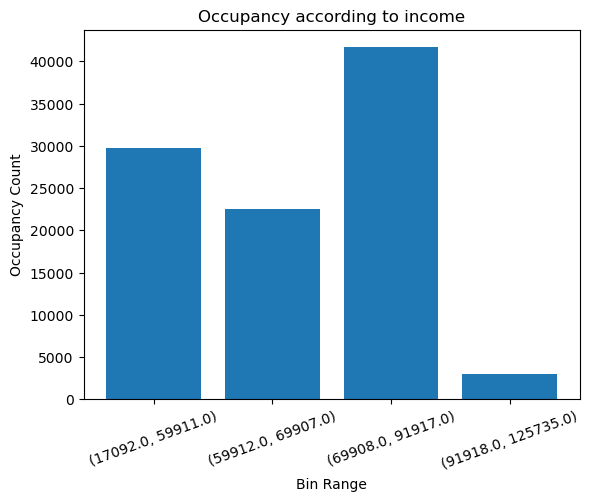

In [18]:
# Creating the bar plot using matplotlib
fig, ax = plt.subplots()
# Initializing the values 
ax.bar(cluster_df['bin_range'], cluster_df['occupancy_count'])

# Setting the label names 
ax.set_title('Occupancy according to income')
ax.set_xlabel('Bin Range')
ax.set_ylabel('Occupancy Count')

#Rotating the X-axis labels for visibility s
plt.xticks(rotation=20)

# Saving the file to the required locatio
plt.savefig('./plots/occupancy_count.png', dpi=300, bbox_inches='tight')

# Displaying the plot
plt.show()